In [ ]:
import torch
import torchvision.models
import numpy as np
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim #for gradient descent
import matplotlib.pyplot as plt

In [ ]:
import random
import math
import os
import requests

In [ ]:
from torchvision import datasets
import torchvision.transforms.v2
from torch.utils.data import DataLoader, Subset
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
class RGBToBGR(nn.Module):
    """Converts Tensors or PIL images from RGB to BGR (or vice versa)."""

    def forward(self, x):
        if isinstance(x, torch.Tensor):
            if x.ndim not in (3, 4):
                raise ValueError('Tensor must have 3 or 4 dimensions.')
            if x.shape[-3] != 3:
                raise ValueError('Tensor must have three channels.')
            return x.flip(dims=[-3])
        elif isinstance(x, Image.Image):
            x = x.convert('RGB')
            return Image.merge('RGB', x.split()[::-1])
        raise TypeError('Argument must be either Tensor or PIL image.')

In [ ]:
# Load your dataset and preprocess it
transform_normal = torchvision.transforms.v2.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[116.047 / 255, 113.753 / 255, 105.417 / 255], std=[1 / 255]),
    RGBToBGR()
])

transform_color = torchvision.transforms.v2.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ColorJitter(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[116.047 / 255, 113.753 / 255, 105.417 / 255], std=[1 / 255])
])

transform_rotate = torchvision.transforms.v2.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.v2.RandomApply(transforms=[
        torchvision.transforms.RandomRotation(degrees=(90,90)),
        torchvision.transforms.RandomRotation(degrees=(180,180)),
        torchvision.transforms.RandomRotation(degrees=(270,270))], p=0.5),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[116.047 / 255, 113.753 / 255, 105.417 / 255], std=[1 / 255])
])

transform_rotate1 = torchvision.transforms.v2.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.RandomRotation(degrees=(90,90)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[116.047 / 255, 113.753 / 255, 105.417 / 255], std=[1 / 255])
])

transform_rotate2 = torchvision.transforms.v2.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.RandomRotation(degrees=(180,180)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[116.047 / 255, 113.753 / 255, 105.417 / 255], std=[1 / 255])
])

transform_rotate3 = torchvision.transforms.v2.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.RandomRotation(degrees=(270,270)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[116.047 / 255, 113.753 / 255, 105.417 / 255], std=[1 / 255])
])

transform_fliph = torchvision.transforms.v2.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[116.047 / 255, 113.753 / 255, 105.417 / 255], std=[1 / 255])
])

transform_flipv = torchvision.transforms.v2.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.RandomVerticalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[116.047 / 255, 113.753 / 255, 105.417 / 255], std=[1 / 255])
])

#transform_rotate = torchvision.transforms.v2.RandomApply(transforms=[transform_rotate1, transform_rotate2,transform_rotate3], p=1)

transform_list = [transform_normal, transform_color, transform_rotate1, transform_rotate2,transform_rotate3, transform_fliph, transform_flipv]

In [ ]:
data_dir = '/content/gdrive/My Drive/APS360 Group Project/datax256_n_500/datax256_n_500'

train_dir = os.path.join(data_dir, 'train/')
val_dir = os.path.join(data_dir, 'val/')
test_dir = os.path.join(data_dir, 'test/')
#splitfolders.ratio(data_dir, output=data_dir, seed=1337, ratio=(.8, 0.1,0.1))

train_datasets = []

for trans in transform_list:
    # Create datasets and dataloaders for training, validation, and test sets
    train_datasets.append(datasets.ImageFolder(train_dir, transform=trans))

from torch.utils.data import ConcatDataset
#train_dataset = ConcatDataset(train_datasets)
train_dataset = datasets.ImageFolder(train_dir, transform=transform_normal)
val_dataset = datasets.ImageFolder(val_dir, transform=transform_normal)
test_dataset = datasets.ImageFolder(test_dir, transform=transform_normal)

In [ ]:
class placesClassifier(nn.Module):
    def __init__(self):
        super(placesClassifier, self).__init__()
        self.fc1 = nn.Linear(205, 50)
        self.fc2 = nn.Linear(50, 4)

    def forward(self, x):
        x1 = F.relu(self.fc1(x))
        x2 = self.fc2(x1)
        return x2

class placesMerged(nn.Module):

    def __init__(self, model1, model2):
        super().__init__()

        self.model1 = model1
        self.model2 = model2


    def forward(self, x):
        x1 = self.model1(x)
        x2 = self.model2(x1)

        return x2

In [ ]:
import numpy as np
from sklearn import svm
import torch

use_cuda = True

# Extract features using GoogLeNet
def extract_features2(model, bs, dataset):
    dataloader = DataLoader(dataset, batch_size=bs, shuffle=True, pin_memory=True)
    features = []
    labels = []
    for data, label in dataloader:
        data = data.cuda()  # Move data to the same device as the model
        with torch.no_grad():  # Ensure that no gradients are calculated
            output = model(data)  # Assuming GoogLeNet returns both output and auxillary output
            if isinstance(output, torch.Tensor):  # Check if the output is a tensor
                output = output.cpu().detach().numpy()  # Convert tensor to numpy array
            features.append(output)
            labels.append(label.numpy())
    features = np.concatenate(features)
    labels = np.concatenate(labels)
    return features, labels

# Flatten the extracted features
def flatten_features(features):
    return features.reshape(features.shape[0], -1)

# Train SVM classifier
def train_svm(features, labels):
    clf = svm.SVC(kernel='linear')
    clf.fit(features, labels)
    return clf

# Evaluate SVM classifier
def evaluate_svm(clf, features, labels):
    accuracy = clf.score(features, labels)
    return accuracy

In [ ]:
#link for caffe to pytorch code below: https://github.com/crowsonkb/pytorch-caffe-models/tree/master

from PIL import Image
import torch
from torch import nn
from torchvision import transforms as T

import torch
from torch import nn


class Inception(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj):
        super().__init__()
        self.conv_1x1 = nn.Conv2d(in_channels, ch1x1, 1)
        self.relu_1x1 = nn.ReLU(inplace=True)
        self.conv_3x3_reduce = nn.Conv2d(in_channels, ch3x3red, 1)
        self.relu_3x3_reduce = nn.ReLU(inplace=True)
        self.conv_3x3 = nn.Conv2d(ch3x3red, ch3x3, 3, padding=1)
        self.relu_3x3 = nn.ReLU(inplace=True)
        self.conv_5x5_reduce = nn.Conv2d(in_channels, ch5x5red, 1)
        self.relu_5x5_reduce = nn.ReLU(inplace=True)
        self.conv_5x5 = nn.Conv2d(ch5x5red, ch5x5, 5, padding=2)
        self.relu_5x5 = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(3, stride=1, padding=1)
        self.pool_proj = nn.Conv2d(in_channels, pool_proj, 1)
        self.relu_pool_proj = nn.ReLU(inplace=True)

    def forward(self, x):
        branch_1 = self.relu_1x1(self.conv_1x1(x))
        branch_2 = self.relu_3x3_reduce(self.conv_3x3_reduce(x))
        branch_2 = self.relu_3x3(self.conv_3x3(branch_2))
        branch_3 = self.relu_5x5_reduce(self.conv_5x5_reduce(x))
        branch_3 = self.relu_5x5(self.conv_5x5(branch_3))
        branch_4 = self.pool(x)
        branch_4 = self.relu_pool_proj(self.pool_proj(branch_4))
        return torch.cat([branch_1, branch_2, branch_3, branch_4], dim=1)

class GoogLeNet2(nn.Sequential):
    def __init__(self, num_classes=1000):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(3, stride=2, ceil_mode=True)
        self.norm1 = nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75)
        self.conv2_reduce = nn.Conv2d(64, 64, kernel_size=1)
        self.relu2_reduce = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(64, 192, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.norm2 = nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75)
        self.pool2 = nn.MaxPool2d(3, stride=2, ceil_mode=True)
        self.inception_3a = Inception(192, 64, 96, 128, 16, 32, 32)
        self.inception_3b = Inception(256, 128, 128, 192, 32, 96, 64)
        self.pool3 = nn.MaxPool2d(3, stride=2, ceil_mode=True)
        self.inception_4a = Inception(480, 192, 96, 208, 16, 48, 64)
        self.inception_4b = Inception(512, 160, 112, 224, 24, 64, 64)
        self.inception_4c = Inception(512, 128, 128, 256, 24, 64, 64)
        self.inception_4d = Inception(512, 112, 144, 288, 32, 64, 64)
        self.inception_4e = Inception(528, 256, 160, 320, 32, 128, 128)
        self.pool4 = nn.MaxPool2d(3, stride=2, ceil_mode=True)
        self.inception_5a = Inception(832, 256, 160, 320, 32, 128, 128)

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.pool1(x)
        x = self.norm1(x)
        x = self.relu2_reduce(self.conv2_reduce(x))
        x = self.relu2(self.conv2(x))
        x = self.norm2(x)
        x = self.pool2(x)
        x = self.inception_3a(x)
        x = self.inception_3b(x)
        x = self.pool3(x)
        x = self.inception_4a(x)
        x = self.inception_4b(x)
        x = self.inception_4c(x)
        x = self.inception_4d(x)
        x = self.inception_4e(x)
        x = self.pool4(x)
        x = self.inception_5a(x)
        return x

class GoogLeNet(nn.Sequential):
    def __init__(self, num_classes=1000):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(3, stride=2, ceil_mode=True)
        self.norm1 = nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75)
        self.conv2_reduce = nn.Conv2d(64, 64, kernel_size=1)
        self.relu2_reduce = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(64, 192, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.norm2 = nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75)
        self.pool2 = nn.MaxPool2d(3, stride=2, ceil_mode=True)
        self.inception_3a = Inception(192, 64, 96, 128, 16, 32, 32)
        self.inception_3b = Inception(256, 128, 128, 192, 32, 96, 64)
        self.pool3 = nn.MaxPool2d(3, stride=2, ceil_mode=True)
        self.inception_4a = Inception(480, 192, 96, 208, 16, 48, 64)
        self.inception_4b = Inception(512, 160, 112, 224, 24, 64, 64)
        self.inception_4c = Inception(512, 128, 128, 256, 24, 64, 64)
        self.inception_4d = Inception(512, 112, 144, 288, 32, 64, 64)
        self.inception_4e = Inception(528, 256, 160, 320, 32, 128, 128)
        self.pool4 = nn.MaxPool2d(3, stride=2, ceil_mode=True)
        self.inception_5a = Inception(832, 256, 160, 320, 32, 128, 128)
        self.inception_5b = Inception(832, 384, 192, 384, 48, 128, 128)
        self.pool5 = nn.AdaptiveAvgPool2d((1, 1))
        self.loss3_classifier = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.pool1(x)
        x = self.norm1(x)
        x = self.relu2_reduce(self.conv2_reduce(x))
        x = self.relu2(self.conv2(x))
        x = self.norm2(x)
        x = self.pool2(x)
        x = self.inception_3a(x)
        x = self.inception_3b(x)
        x = self.pool3(x)
        x = self.inception_4a(x)
        x = self.inception_4b(x)
        x = self.inception_4c(x)
        x = self.inception_4d(x)
        x = self.inception_4e(x)
        x = self.pool4(x)
        x = self.inception_5a(x)
        x = self.inception_5b(x)
        x = self.pool5(x).flatten(1)
        return self.loss3_classifier(x)

class Just_5b(nn.Module):
    def __init__(self):
        super(Just_5b, self).__init__()
        self.inception_5b = Inception(832, 384, 192, 384, 48, 128, 128)
        self.pool5 = nn.AdaptiveAvgPool2d((1, 1))
        self.loss3_classifier = nn.Linear(1024, 205)

    def forward(self, x):
        x = self.inception_5b(x)
        x = self.pool5(x).flatten(1)
        x = self.loss3_classifier(x)
        return x


class RGBToBGR(nn.Module):
    """Converts Tensors or PIL images from RGB to BGR (or vice versa)."""

    def forward(self, x):
        if isinstance(x, torch.Tensor):
            if x.ndim not in (3, 4):
                raise ValueError('Tensor must have 3 or 4 dimensions.')
            if x.shape[-3] != 3:
                raise ValueError('Tensor must have three channels.')
            return x.flip(dims=[-3])
        elif isinstance(x, Image.Image):
            x = x.convert('RGB')
            return Image.merge('RGB', x.split()[::-1])
        raise TypeError('Argument must be either Tensor or PIL image.')


def googlenet_places205():
    """Returns the model and preprocessing transform for the GoogLeNet
    trained on Places205.

    URL: http://places.csail.mit.edu/downloadCNN.html"""

    transform = T.Compose([
        T.Normalize(mean=[116.047 / 255, 113.753 / 255, 105.417 / 255], std=[1 / 255]),
        RGBToBGR(),
    ])
    model = GoogLeNet(num_classes=205)
    url = 'https://github.com/crowsonkb/pytorch-caffe-models/releases/download/models-2/googlenet_places205-b57a3fc7a34557585.pth'
    model.load_state_dict(torch.hub.load_state_dict_from_url(url, check_hash=True))
    return model, transform

def load_my_state_dict(self, state_dict):

        own_state = self.state_dict()
        for name, param in state_dict.items():
            if name not in own_state:
                 continue
            own_state[name].copy_(param)
        return own_state

In [ ]:
def get_accuracy1(extract, model, bs, data_loader):
    correct = 0
    total = 0
    for data, labels in data_loader:
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          data = data.cuda()
          labels = labels.cuda()
        #############################################

        output = model(extract(data))

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()

        total += data.shape[0]
    return correct / total

def training1(extract, model, train_dataset, valid_dataset, bs=32, num_epoch=5, lr=0.001, graph=False):
    """
    extract: type of model used for feature extraction
    model: type of classifier used on extracted features
    train_loader: DataLoader of training data
    valid_loader: DataLoader of validation data
    bs: batch size
    num_epoch: number of epochs
    lr: learning rate
    graph: boolean, whether a graph is to be produced
    """
    train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, pin_memory=True)
    valid_loader = DataLoader(valid_dataset, batch_size=bs, shuffle=True, pin_memory=True)

    torch.manual_seed(1)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.9)

    t_losses, iters, t_acc, v_acc, g_iter = [], [], [], [], []

    i = 0

    for epoch in range(num_epoch):
        for data, labels in train_loader:

            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              data = data.cuda()
              labels = labels.cuda()
            #############################################

            output = model(extract(data))
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            t_losses.append(float(loss/bs))

            iters.append(i)
            i += 1

        if graph:
            t_acc.append(get_accuracy1(extract, model, bs, train_loader))
            v_acc.append(get_accuracy1(extract, model, bs, valid_loader))
            g_iter.append(epoch)

    if graph:
        plt.title("Training Curve")
        plt.plot(iters, t_losses, label="Train")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.show()

        plt.title("Training Curve")
        plt.plot(g_iter, t_acc, label="Train")
        plt.plot(g_iter, v_acc, label="Validation")
        plt.xlabel("Epochs")
        plt.ylabel("Training Accuracy")
        plt.legend(loc='best')
        plt.show()

    print("Final Training Accuracy: {}".format(get_accuracy1(extract, model, bs, train_loader)))
    print("Final Validation Accuracy: {}".format(get_accuracy1(extract, model, bs, valid_loader)))

In [ ]:
# Load pre-trained GoogLeNet pretrained on Places205
googlenet_places, transform = googlenet_places205()
classifier = placesClassifier()
not_5b = GoogLeNet2()
not_5b.load_state_dict(load_my_state_dict(not_5b, googlenet_places.state_dict()))
just_5b = Just_5b()

merged_net = placesMerged(just_5b, classifier)

model = merged_net

Downloading: "https://github.com/crowsonkb/pytorch-caffe-models/releases/download/models-2/googlenet_places205-b57a3fc7a34557585.pth" to /root/.cache/torch/hub/checkpoints/googlenet_places205-b57a3fc7a34557585.pth
100%|██████████| 23.6M/23.6M [00:00<00:00, 76.0MB/s]


In [ ]:
'''
use_cuda = True

if use_cuda and torch.cuda.is_available():
  model = model.cuda()
  not_5b = not_5b.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

# Freeze initial layers
for name, param in not_5b.named_parameters():
    param.requires_grad = False

# Don't freeze final layers
for name, param in model.named_parameters():
    param.requires_grad = True

training1(not_5b,model,train_dataset, val_dataset, bs=32, num_epoch=10, lr=0.01, graph=True)


'''

"\nuse_cuda = True\n\nif use_cuda and torch.cuda.is_available():\n  model = model.cuda()\n  not_5b = not_5b.cuda()\n  print('CUDA is available!  Training on GPU ...')\nelse:\n  print('CUDA is not available.  Training on CPU ...')\n\n# Freeze initial layers\nfor name, param in not_5b.named_parameters():\n    param.requires_grad = False\n\n# Don't freeze final layers\nfor name, param in model.named_parameters():\n    param.requires_grad = True\n\ntraining1(not_5b,model,train_dataset, val_dataset, bs=32, num_epoch=10, lr=0.01, graph=True)\n\n\n"

In [ ]:
#torch.save(model.state_dict(), '/content/gdrive/My Drive/APS360 Group Project/model_state_32_10_0_01.pth')

In [ ]:
use_cuda = True

if use_cuda and torch.cuda.is_available():
  model = model.cuda()
  not_5b = not_5b.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

# Freeze initial layers
for name, param in not_5b.named_parameters():
    param.requires_grad = False

# Don't freeze final layers
for name, param in model.named_parameters():
    param.requires_grad = True

saved_state_path = '/content/gdrive/My Drive/APS360 Group Project/model_state_32_10_0_01.pth'
saved_state_dict = torch.load(saved_state_path)

# Load the state dictionary into your model
model.load_state_dict(saved_state_dict)

# Ensure model is in evaluation mode
model.eval()

CUDA is available!  Training on GPU ...


placesMerged(
  (model1): Just_5b(
    (inception_5b): Inception(
      (conv_1x1): Conv2d(832, 384, kernel_size=(1, 1), stride=(1, 1))
      (relu_1x1): ReLU(inplace=True)
      (conv_3x3_reduce): Conv2d(832, 192, kernel_size=(1, 1), stride=(1, 1))
      (relu_3x3_reduce): ReLU(inplace=True)
      (conv_3x3): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu_3x3): ReLU(inplace=True)
      (conv_5x5_reduce): Conv2d(832, 48, kernel_size=(1, 1), stride=(1, 1))
      (relu_5x5_reduce): ReLU(inplace=True)
      (conv_5x5): Conv2d(48, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (relu_5x5): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
      (pool_proj): Conv2d(832, 128, kernel_size=(1, 1), stride=(1, 1))
      (relu_pool_proj): ReLU(inplace=True)
    )
    (pool5): AdaptiveAvgPool2d(output_size=(1, 1))
    (loss3_classifier): Linear(in_features=1024, out_features=205, bias=True)
  )

In [ ]:
for name, param in model.named_parameters():
    param.requires_grad = False

just_5b = model.model1
both = placesMerged(not_5b, just_5b)

train_features, train_labels = extract_features2(both, 32, train_dataset)
val_features, val_labels = extract_features2(both, 32, val_dataset)
test_features, test_labels = extract_features2(both, 32, test_dataset)

# Convert features to PyTorch tensors
train_features_tensor = torch.FloatTensor(train_features)
train_labels_tensor = torch.LongTensor(train_labels)
val_features_tensor = torch.FloatTensor(val_features)
val_labels_tensor = torch.LongTensor(val_labels)
test_features_tensor = torch.FloatTensor(test_features)
test_labels_tensor = torch.LongTensor(test_labels)

In [ ]:
from sklearn.model_selection import GridSearchCV

#classifier = model.model2

train_features_tensor = train_features_tensor.cuda().detach().cpu().numpy()
test_features_tensor = test_features_tensor.cuda().detach().cpu().numpy()
val_features_tensor = val_features_tensor.cuda().detach().cpu().numpy()

# Extract features using the trained classifier
'''
Should this be classifier(train_features_tensor) or just train_features_tensor?
'''
#train_features_classifier = classifier(train_features_tensor).detach().cpu().numpy()
#test_features_classifier = classifier(test_features_tensor).detach().cpu().numpy()
#val_features_classifier = classifier(val_features_tensor).detach().cpu().numpy()


# Define hyperparameters
svm_params = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'kernel': ['linear', 'poly', 'rbf'],  # Kernel type
    'degree': [2, 3, 4],  # Degree of the polynomial kernel
    'gamma': ['scale', 'auto']  # Gamma parameter for RBF kernel
}

# Train SVM classifier on extracted features with grid search
svm_classifier = svm.SVC()
grid_search_svm = GridSearchCV(svm_classifier, svm_params, cv=5, n_jobs=-1)
grid_search_svm.fit(train_features_tensor, train_labels)

# Get best parameters
best_params_svm = grid_search_svm.best_params_
print("Best Parameters (SVM):", best_params_svm)

# Evaluate SVM classifier with best parameters on test set
best_svm_classifier = grid_search_svm.best_estimator_
val_accuracy_svm = best_svm_classifier.score(val_features_tensor, val_labels)
print(f"Val Accuracy (SVM with Grid Search): {val_accuracy_svm:.4f}")


Best Parameters (SVM): {'C': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
Val Accuracy (SVM with Grid Search): 0.6600


In [ ]:
from sklearn.model_selection import GridSearchCV

classifier = model.model2


# Extract features using the trained classifier
train_features_tensor2 = torch.FloatTensor(train_features)
train_labels_tensor2 = torch.LongTensor(train_labels)
val_features_tensor2 = torch.FloatTensor(val_features)
val_labels_tensor2 = torch.LongTensor(val_labels)
test_features_tensor2 = torch.FloatTensor(test_features)
test_labels_tensor2 = torch.LongTensor(test_labels)

train_features_tensor2 = train_features_tensor2.cuda()
test_features_tensor2 = test_features_tensor2.cuda()
val_features_tensor2 = val_features_tensor2.cuda()


train_features_classifier = classifier(train_features_tensor2).detach().cpu().numpy()
test_features_classifier = classifier(test_features_tensor2).detach().cpu().numpy()
val_features_classifier = classifier(val_features_tensor2).detach().cpu().numpy()


# Define hyperparameters
svm_params2 = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'kernel': ['linear', 'poly', 'rbf'],  # Kernel type
    'degree': [2, 3, 4],  # Degree of the polynomial kernel
    'gamma': ['scale', 'auto']  # Gamma parameter for RBF kernel
}

# Train SVM classifier on extracted features with grid search
svm_classifier2 = svm.SVC()
grid_search_svm2 = GridSearchCV(svm_classifier2, svm_params2, cv=5, n_jobs=-1)
grid_search_svm2.fit(train_features_classifier, train_labels)

# Get best parameters
best_params_svm2 = grid_search_svm2.best_params_
print("Best Parameters (SVM):", best_params_svm2)

# Evaluate SVM classifier with best parameters on test set
best_svm_classifier2 = grid_search_svm2.best_estimator_
val_accuracy_svm2 = best_svm_classifier2.score(val_features_classifier, val_labels)
print(f"Val Accuracy (Classifier + SVM with Grid Search): {val_accuracy_svm2:.4f}")


Best Parameters (SVM): {'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
Val Accuracy (Classifier + SVM with Grid Search): 0.6550


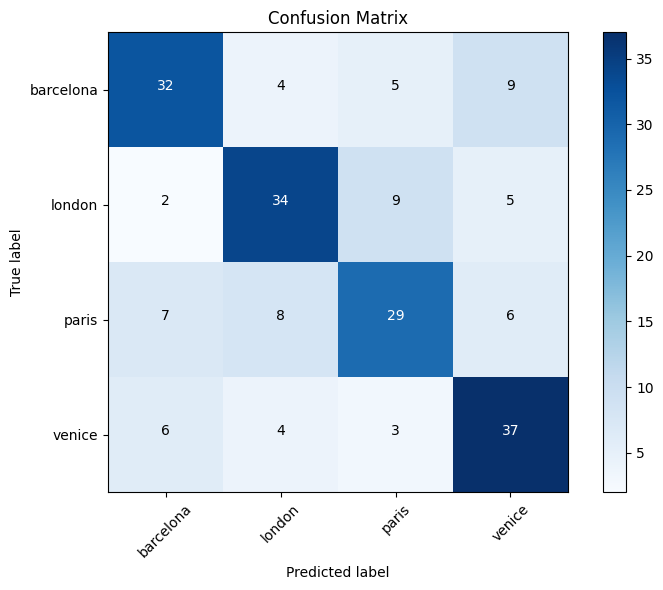

              precision    recall  f1-score   support

   barcelona       0.68      0.64      0.66        50
      london       0.68      0.68      0.68        50
       paris       0.63      0.58      0.60        50
      venice       0.65      0.74      0.69        50

    accuracy                           0.66       200
   macro avg       0.66      0.66      0.66       200
weighted avg       0.66      0.66      0.66       200



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

class_names = ['barcelona', 'london', 'paris', 'venice']   # Adjust class names accordingly


# Get predictions on the test set
val_predictions_svm = best_svm_classifier.predict(val_features_tensor)

# Calculate confusion matrix
conf_matrix = confusion_matrix(val_labels, val_predictions_svm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, str(conf_matrix[i, j]), horizontalalignment="center", color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# Plot classification report
print(classification_report(val_labels, val_predictions_svm, target_names=class_names))

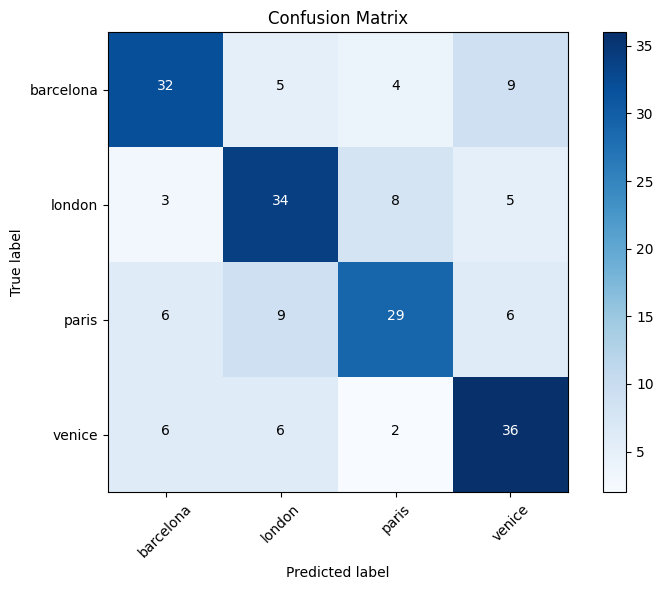

              precision    recall  f1-score   support

   barcelona       0.68      0.64      0.66        50
      london       0.63      0.68      0.65        50
       paris       0.67      0.58      0.62        50
      venice       0.64      0.72      0.68        50

    accuracy                           0.66       200
   macro avg       0.66      0.66      0.65       200
weighted avg       0.66      0.66      0.65       200



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

class_names = ['barcelona', 'london', 'paris', 'venice']  # Adjust class names accordingly


# Get predictions on the test set
val_predictions_svm2 = best_svm_classifier2.predict(val_features_classifier)

# Calculate confusion matrix
conf_matrix = confusion_matrix(val_labels, val_predictions_svm2)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, str(conf_matrix[i, j]), horizontalalignment="center", color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# Plot classification report
print(classification_report(val_labels, val_predictions_svm2, target_names=class_names))

In [ ]:
test_accuracy_svm = best_svm_classifier.score(test_features_tensor, test_labels)
print(f"Test Accuracy (SVM with Grid Search): {test_accuracy_svm:.4f}")

Test Accuracy (SVM with Grid Search): 0.5800


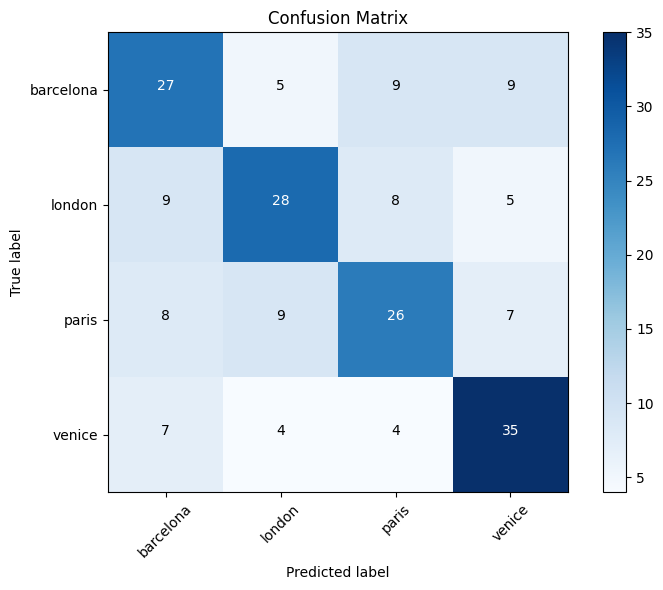

              precision    recall  f1-score   support

   barcelona       0.53      0.54      0.53        50
      london       0.61      0.56      0.58        50
       paris       0.55      0.52      0.54        50
      venice       0.62      0.70      0.66        50

    accuracy                           0.58       200
   macro avg       0.58      0.58      0.58       200
weighted avg       0.58      0.58      0.58       200



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

class_names = ['barcelona', 'london', 'paris', 'venice']  # Adjust class names accordingly


# Get predictions on the test set
test_predictions_svm = best_svm_classifier.predict(test_features_tensor)

# Calculate confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions_svm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, str(conf_matrix[i, j]), horizontalalignment="center", color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# Plot classification report
print(classification_report(test_labels, test_predictions_svm, target_names=class_names))